In [108]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import time
import numpy as np

from SES_setup import *
from utils import *
from style import *

In [342]:
def rate_to_state(init_rho, final_rho, L):
    rho_dot = qt.vector_to_operator(L*qt.operator_to_vector(init_rho))
    return (rho_dot*final_rho).tr()

def rate_to_manifold(init_rho, L, ops, manifold='OO'):
    if manifold == 'ground':
        manifold = 'OO'
    rho_dot = qt.vector_to_operator(L*qt.operator_to_vector(init_rho))
    return (rho_dot*ops[manifold]).tr()

def proper_rate_to_manifold(init_rho, L, PARAMS, manifold='dark', exc_cutoff=1e3):
    rho_dot = qt.vector_to_operator(L*qt.operator_to_vector(init_rho))
    energies, states = exciton_states(PARAMS)
    stdict = {'dark' : states[0], 'bright' : states[1], 'ground' : OO}
    rate = 0
    
    for n1 in range(PARAMS['N_1']):
        for n2 in range(PARAMS['N_2']):
            if (n1+n2) <= exc_cutoff:
            #if ((n2+n1) <PARAMS['exc']):
                state = tensor(stdict[manifold], qt.basis(PARAMS['N_1'], n1), qt.basis(PARAMS['N_2'], n2))
                rate += (state.dag()*rho_dot*state).tr()
            elif (n1+n2)>exc_cutoff+1: # Want to really make sure I get all of the same excitation num
                return rate
            else:
                pass
    return rate

# Displacements
Defining everything via the IBM hamiltonian and taking into account the normalisation of the displacement operator gives the right answers for this known test case. However, with RC mapping parameters and spectral densities taken from the [J. Chem. Phys paper](https://aip.scitation.org/doi/10.1063/1.4940218) and the Liouvillians defined in my code/notes, which agree with Redfield without any hacky prefactors, it appears like $\alpha_{ph}$ is missing a factor of 4 (or $\kappa$ is missing a factor of 2). This gives a factor of 2 error in the displacment of the modes. I think my approach now will be to include a factor of $1/2$ in the definition of the displacement, so that the re. I'll fully resolve this issue later on.

In [110]:
80/ev_to_inv_cm

0.00991878990763127

In [111]:
def plot_decay_rates(data_dict, couplings):
    for w0, dat in data_dict.items(): # for each w0, unpack data which is dictionary with keys [btd, dtg, btg]
        # for each set of rates, plot a new figure
        displacements = [c/float(w0) for c in couplings] 
        for rate_type, rate_data in dat.items(): # for each set of rates, plot each
            plt.figure()
            plt.title(rate_type +' '+ w0)
            for label, data_set in rate_data.items():
                if (rate_type != 'btd') and (label == 'wc'):
                    data_set = np.array(data_set)
                if (label != 'wc'):
                    plt.plot(displacements, data_set, label=label)
            plt.legend()

In [112]:
def sort_eigs(evals, evecs):
    idx = evals.argsort()
    return evals[idx], evecs[idx]

def dark_bright_check(states, ops):
    # ensures the states have the correct symmetry properties
    dark_states = states['dark']
    bright_states = states['bright']
    ground_states = states['ground']
    i = 0
    for g in ground_states:
        assert abs((g*g.dag()*ops["OO"]).tr()-1) <1e-10
        for d in dark_states:
            assert abs((d.dag()*g).tr()) <1e-10
    for d in dark_states:
        #print((d.dag()*d).tr())
        assert abs((d.dag()*d).tr()-1) <1e-10
        for b in bright_states:
            #print ((d.dag()*b))
            assert abs((b.dag()*b).tr()-1) <1e-10
            assert abs((d.dag()*b).tr()) <1e-10
            assert abs((d.dag()*d).tr()-1) <1e-10
            i += 1

            

def separate_states(H, PARAMS, trunc=0.8):
    # truncation removes the really dodgy states for which the parity is unclear 
    # (this might not be numerical error, but it probs is)
    ops = make_expectation_operators(PARAMS)
    energies, states = H.eigenstates()
    energies, states = sort_eigs(energies, states)
    energies, states = energies[0:int(len(states)*trunc)], states[0:int(len(states)*trunc)]
    parities = [(state*state.dag()*ops['sigma_x']).tr() for state in states]
    phonon_occ_dict = {'dark': [], 'bright': [], 'ground': []}
    states_dict = {'dark': [], 'bright': [], 'ground': []}
    energies_dict = {'dark': [], 'bright': [], 'ground': []} # for checking
    for i, parity in enumerate(parities):
        occ_1 = (states[i].dag()*ops['RC1_number']*states[i]).tr().real
        occ_2 = (states[i].dag()*ops['RC2_number']*states[i]).tr().real
        if abs(parity)<1e-10:
            states_dict['ground'].append(states[i])
            energies_dict['ground'].append(energies[i])
            phonon_occ_dict['ground'].append((occ_1, occ_2))
        elif parity>1e-10:
            states_dict['bright'].append(states[i])
            energies_dict['bright'].append(energies[i])
            phonon_occ_dict['bright'].append((occ_1, occ_2))
        elif parity<-1e-10:
            states_dict['dark'].append(states[i])
            energies_dict['dark'].append(energies[i])
            phonon_occ_dict['dark'].append((occ_1, occ_2))
        else:
            raise ValueError("Parity is {} ".format(parity))
    if len(states_dict['ground'])  == len(states):
        print("This will not work for V=0. Ground contains all states.")
    #print(len(states_dict['dark']), len(states_dict['bright']), len(states_dict['ground']))
    #assert (len(states_dict['dark']) == len(states_dict['bright']))
    dark_bright_check(states_dict, ops)
    return energies_dict, states_dict, phonon_occ_dict

# Low Temperature characterisation

In the first instance, I need to understand what happens at low phonon and EMF temperature. Just choose some sensible parameters (say from monomer paper or Dominic's dimer paper) and calculate. $\omega_0 = 30meV, 60meV, 120meV$
- $|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=0$
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=0$ Does increasing phonon coupling actually increase population of dark state? Is this because $\sigma_x$ gains displacement operators?
- $|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=0$ 

Then I'll be in a position to understand EMF thermal occupation. Steadystate population is likely to be $\propto\Gamma_{g,+}/\Gamma_{-,0}$, unless dominated by phonon reorganisation.
- $|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=6000$

Can I then characterise population by $\Gamma_{g,+}/\Gamma_{-,0}$? In the first instance just from zero states to manifolds.

In [327]:
def displace(offset, a):
    return (offset*(a.dag())/sqrt(2) - offset.conjugate()*a/sqrt(2)).expm()

def undisplaced_initial(init_sys, PARAMS):
    n1 = Occupation(PARAMS['w0_1'], PARAMS['T_1'])
    n2 = Occupation(PARAMS['w0_2'], PARAMS['T_2'])
    return tensor(init_sys, qt.enr_thermal_dm([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'], 
                                              [n1, n2]))
def position_ops(PARAMS):
    atemp = enr_destroy([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    return [tensor(I_sys, (a + a.dag())/sqrt(2)) for a, omega in zip(atemp, [PARAMS['w0_1'], PARAMS['w0_2']])]


def offsets(init_sys, PARAMS):
    energies, states = exciton_states(PARAMS)
    normal_disp_1 = sqrt(pi*PARAMS['alpha_1']/(2*PARAMS['w0_1']))
    normal_disp_2 = sqrt(pi*PARAMS['alpha_2']/(2*PARAMS['w0_2']))
    eta = sqrt(PARAMS['bias']+4*PARAMS['V'])
    coeff_p = (eta + PARAMS['bias'])/(2*eta)
    coeff_m = (eta - PARAMS['bias'])/(2*eta)
    if init_sys == 'dark':
        return states[0], normal_disp_1*coeff_m, normal_disp_2*coeff_p
    elif init_sys == 'bright':
        return states[1], normal_disp_1*coeff_p, normal_disp_2*coeff_m
    elif init_sys == 'ground':
        return OO, 0, 0
    else:
        raise KeyError("Please choose dark, bright or ground")

def displaced_initial(PARAMS, init_sys='dark', silent=False, return_error=False):
    init_state, offset_1, offset_2 = offsets(init_sys, PARAMS)
    atemp = enr_destroy([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    x = position_ops(PARAMS)
    r0 = undisplaced_initial(init_state*init_state.dag(), PARAMS)
    disp = copy.deepcopy(r0)
    for offset, a_ in zip([offset_1, offset_2], atemp):
        d = tensor(I_sys, displace(offset, a_))
        disp =  d * disp * d.dag()
    try:
        error = 100*(abs((disp*x[0]).tr()- offset_1)/offset_1 + abs((disp*x[1]).tr()- offset_2)/offset_2)
        if error>0.5:
            print ("Error in displacement: {:0.8f}%. Predicted {:0.4f} , actual {:0.4f}".format(error, offset_1, (disp*x[0]).tr()))
            print ("Ratio of kBT to Omega: {:0.4f}".format(0.695*PARAMS['T_1']/PARAMS['w0_1']))
            if ((PARAMS['T_1'] != PARAMS['T_2']) or (PARAMS['w0_1'] != PARAMS['w0_2'])):
               print("Ratio of kBT to Omega (2): {:0.4f}".format(0.695*PARAMS['T_2']/PARAMS['w0_2']))
        if return_error:   
            return disp, error
        else:
            return disp
    except:
        return disp

def thermal_manifold(energies_dict, states_dict, T, manifold='bright'):

    if manifold == 'both':
        states = list(states_dict['bright']) + list(states_dict['dark'])
        energies = list(energies_dict['bright']) + list(energies_dict['bright'])
    else:
        states = states_dict[manifold]
        energies = energies_dict[manifold]
    
    thermal_unnormalised = (-beta_f(T)*sum([E*K*K.dag() for E, K in zip(energies, states)])).expm()
    #print(thermal_unnormalised.ptrace(0))
    return thermal_unnormalised/thermal_unnormalised.tr()


In [249]:
w_2 = 1.4 * ev_to_inv_cm
bias = 0 # 10e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 100e-3 * ev_to_inv_cm
T_EM = 6000.
T_ph = 77.
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
#w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 800. #2*w0
w0 = 30e-3*ev_to_inv_cm
print (eta, V/eta)
N=7

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)


161.31 0.5


In [282]:
rt = thermal_manifold(energies_dict, states_dict, T_ph, manifold='ground')

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 1.02210655  0.          0.        ]
 [ 0.         49.          0.        ]
 [ 0.          0.         49.        ]]


In [288]:
help(Qobj)

Help on class Qobj in module qutip.qobj:

class Qobj(builtins.object)
 |  A class for representing quantum objects, such as quantum operators
 |  and states.
 |  
 |  The Qobj class is the QuTiP representation of quantum operators and state
 |  vectors. This class also implements math operations +,-,* between Qobj
 |  instances (and / by a C-number), as well as a collection of common
 |  operator/state operations.  The Qobj constructor optionally takes a
 |  dimension ``list`` and/or shape ``list`` as arguments.
 |  
 |  Parameters
 |  ----------
 |  inpt : array_like
 |      Data for vector/matrix representation of the quantum object.
 |  dims : list
 |      Dimensions of object used for tensor products.
 |  shape : list
 |      Shape of underlying data structure (matrix shape).
 |  copy : bool
 |      Flag specifying whether Qobj should get a copy of the
 |      input data, or use the original.
 |  fast : bool
 |      Flag for fast qobj creation when running ode solvers.
 |      This

In [283]:
rt.ptrace(0)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.010322 0.       0.      ]
 [0.       0.494839 0.      ]
 [0.       0.       0.494839]]

In [114]:
def plot_manifold_rates(data_dict, title = 'dtg', show_total_decay=False):
    couplings =data_dict['couplings']
    for omega_0, data in data_dict.items():
        if omega_0 == 'couplings':
            couplings = data
        else:
            plt.figure()
            plt.title(title+ ' ' + omega_0)
            i=0
            for rate_name, rate_data in data.items():
                if(  (abs(sum(rate_data['nonadd'])) <1e-9)):
                    pass # we don't really want the total decay rate in there, or any that are zero
                else:
                    c = colourWheel[i]
                    plt.plot(couplings, rate_data['nonadd'], linestyle='solid', label=rate_name, c=c) 
                    plt.plot(couplings, rate_data['add'], linestyle='dashed', c=c)
                    i+=1
            plt.legend()

In [343]:
def thermal_to_states(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., T_EM=0.,
                         N=5, start_manifold='dark', end_manifold='OO'):
    # Characterise low T_ph behaviour of decay
    eta = sqrt(bias**2 + 4*V**2)
    Omegas = np.array([ 30e-3, 60e-3, 120e-3])*ev_to_inv_cm
    couplings = np.linspace(0.1,50,20)
    data_names = ["{}".format(int(i)) for i in Omegas]
    in_in_dict = {'nonadd':[], 'add': []}
    state_indexes = [0,0,1,2,3,4,5]
    data_dict = {}
    #                   'btd': copy.deepcopy(in_in_dict)} for key in data_names}
    i = 0
    for w_0 in Omegas:
        inner_data_dict = {'st-manifold': copy.deepcopy(in_in_dict),
                'st-f0': copy.deepcopy(in_in_dict), 
               'st-f1': copy.deepcopy(in_in_dict),
               'st-f2': copy.deepcopy(in_in_dict),
               'st-f3': copy.deepcopy(in_in_dict),
                'st-f4': copy.deepcopy(in_in_dict),
                'st-f5': copy.deepcopy(in_in_dict)}
        for alpha in couplings:
            #N=3
            PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                              silent=True, exc_diff=N)
            #PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
            H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
            energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
            print(energies_dict['dark'][0], energies_dict['bright'][0])
            ops = make_expectation_operators(PARAMS)
            ri = displaced_initial(PARAMS, init_sys=start_manifold, silent=False, return_error=False)
            #ri = thermal_manifold(energies_dict, states_dict, T_ph, manifold=start_manifold)
            LVN  = -1j*(qt.spre(H[1]) - qt.spost(H[1]))
            cutoff = 1e3
            for idx, state_label in zip(state_indexes, inner_data_dict.keys()):
                if state_label == 'st-manifold': # Can check decay to whole target manifold
                    #inner_data_dict[state_label]['nonadd'].append(rate_to_manifold(ri, LVN+L['nonadd'], 
                    #                                                         ops, manifold=end_manifold))
                    #inner_data_dict[state_label]['add'].append(rate_to_manifold(ri, LVN+L['add'], 
                    #                                                         ops, manifold=end_manifold))
                    inner_data_dict[state_label]['nonadd'].append(proper_rate_to_manifold(ri, LVN+L['nonadd'], 
                                                                             PARAMS, manifold=end_manifold, 
                                                                                          exc_cutoff=cutoff))
                    inner_data_dict[state_label]['add'].append(proper_rate_to_manifold(ri, LVN+L['add'], 
                                                                             PARAMS, manifold=end_manifold, 
                                                                                          exc_cutoff=cutoff))
                else:
                    sf = states_dict[end_manifold][idx]
                    rf = sf*sf.dag()
                    #rf = thermal_manifold(energies_dict, states_dict, T_ph, manifold=end_manifold)
                    inner_data_dict[state_label]['nonadd'].append(rate_to_state(ri, rf, LVN+L['nonadd']))
                    inner_data_dict[state_label]['add'].append(rate_to_state(ri, rf, LVN+L['add']))
            i+=1
            if i%10 == 0:
                print (i)
        data_dict.update({str(int(w_0)) : inner_data_dict})
    print("Calculation complete")
    data_dict.update({'couplings' : couplings})
    return data_dict

In [336]:
w_2 = 1.4 * ev_to_inv_cm
bias = 0 # 10e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 1e-3 * ev_to_inv_cm
T_EM = 6000.
T_ph = 77.
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
#w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 800. #2*w0
w0 = 30e-3*ev_to_inv_cm
print (eta, V/eta)
N=5

161.31 0.5


In [201]:
def rate_to_manifold(init_rho, Liouv, ops, ):
    rho_dot = qt.vector_to_operator(Liouv*qt.operator_to_vector(init_rho))
    return (rho_dot*ops).ptrace(0)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
ops = make_expectation_operators(PARAMS)
LVN  = -1j*(qt.spre(H[1]) - qt.spost(H[1]))
L_ = L['add']+LVN
#ri = states_dict['bright'][0] #displaced_initial(PARAMS, init_sys=start_manifold, silent=False, return_error=False)
ri = displaced_initial(PARAMS, init_sys='bright', silent=False, return_error=False)
rf = displaced_initial(PARAMS, init_sys='dark', silent=False, return_error=False)

rate_E = rate_to_state(ri, rf, L_)

Error in displacement: 0.77435476%. Predicted 1.1441 , actual 1.1397
Ratio of kBT to Omega: 0.2212
Error in displacement: 0.77435476%. Predicted 1.1441 , actual 1.1397
Ratio of kBT to Omega: 0.2212


In [202]:
print (rate_E)
energies, states = exciton_states(PARAMS)
(states[0]*states[0].dag())*rate_E

(5.647869324998389e-14+2.3915331520685257e-15j)


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

In [345]:
77*0.695

53.51499999999999

In [344]:

dark_ground_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='dark', end_manifold='ground')
ground_dark_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='ground', end_manifold='dark')

11211.076412255312 11372.198377090293
11211.898765086702 11368.375623363187
11212.716033523244 11365.00714314226
11213.528199053158 11361.983982816708
11214.335244628754 11359.234799884576
11215.137155169958 11356.709864765442
11215.9339180361 11354.372879806755
11216.725523466102 11352.196398438207
11217.511964987261 11350.159078372842
11218.29323979286 11348.243943679736
10
11219.06934908877 11346.437236476857
11219.840298409326 11344.727630579562
11220.606097902732 11343.105676586001
11221.366762586313 11341.563400118339
11222.122312571973 11340.0940044403
11222.872773262241 11338.691646041783
11223.618175517358 11337.35126238201
11224.358555793933 11336.06843765734
11225.093956255658 11334.83929677912
11225.824424856824 11333.660420611206
20
11211.064633161604 11372.315744425745


KeyboardInterrupt: 

In [ ]:
plot_manifold_rates(dark_ground_high_T, title='dtg')
plot_manifold_rates(ground_dark_high_T, title='gtd')

In [120]:
bright_ground_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='bright', end_manifold='ground')
ground_bright_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='ground', end_manifold='bright')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete


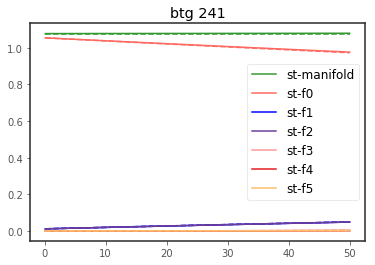

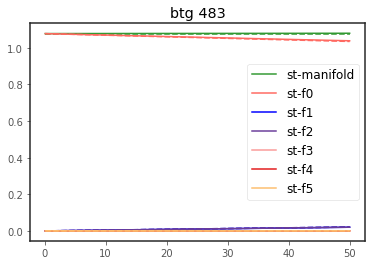

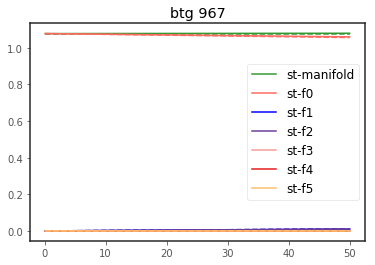

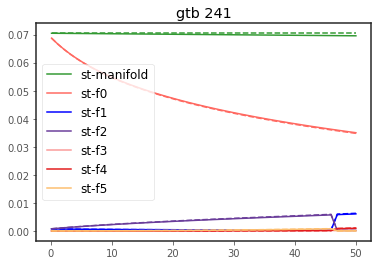

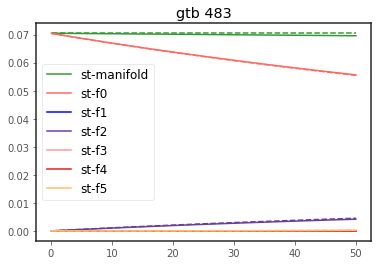

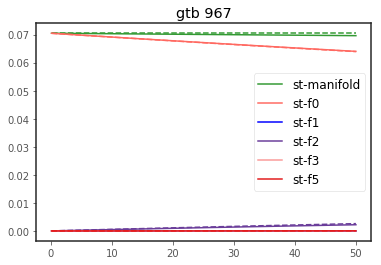

In [122]:
plot_manifold_rates(bright_ground_high_T, title='btg')
plot_manifold_rates(ground_bright_high_T, title='gtb')

In [333]:
bright_dark_high_T

{'241': {'st-manifold': {'nonadd': [None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None],
   'add': [None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,


In [341]:
bright_dark_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='bright', end_manifold='dark')
dark_bright_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='dark', end_manifold='bright')


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
40
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

20
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.2683110912916953e-12
1.2683110912916953e-12
1.2683110912916953e-12
1.2683110912916953e-12
2.5411372341616366e-12
2.5411372341616366e-12
2.5411372341616366e-12
2.5411372341616366e-12
2.5411372341616366e-12
2.5411372341616366e-12
2.5411372341616366e-12
2.5411372341616366e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.2683111046938381e-12
1.2683111046938381e-12
1.2683111046938381e-12
1.2683111046938381e-12
2.541137260753121e-12
2.541137260753121e-12
2.541137260753121e-12
2.541137260753121e-12
2.541137260753121e-12
2.541137260753121e-12
2.541137260753121e-12
2.541137260753121e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
60
Calculation complete


In [339]:
dark_bright_high_T

{'241': {'st-manifold': {'nonadd': [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0],
   'add': [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0]},
  'st-f0': {'nonadd': [(-0.3869939535438441-7.791312470327582e-14j),
    (-9.475141558071549-2.4924491418367317e-12j),
    (-17.03380819117066-1.4199930352467677e-13j),
    (-23.56363783036264-1.2075123569489651e-12j),
    (-29.351087794536763+2.1998487696409556e-13j),
    (-34.575130472185265+5.507965313735519e-13j),
    (-39.3550262004845+9.958909328971e-13j),
    (-43.77426537926797-8.257558716506766e-13j),
    (-47.89362510432598-1.9419504137595905e-12j),
    (-51.75877424686222-9.657183735801715e-13j),
    (-55.404943757727054+1.0661917857341674e-13j),
    (-58.85992206901102+1.32873273

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


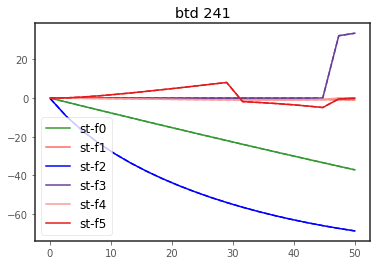

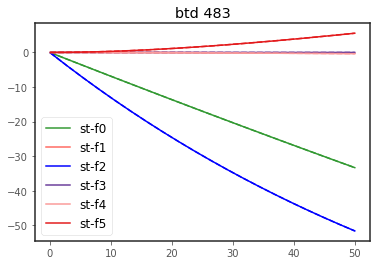

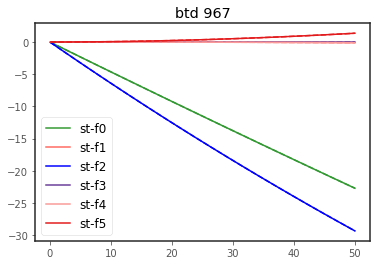

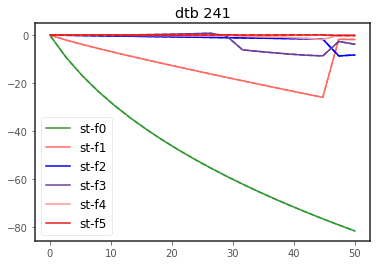

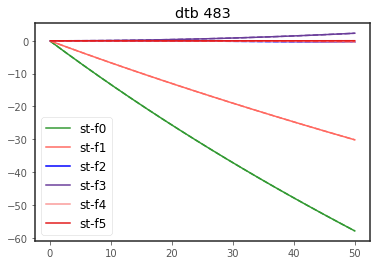

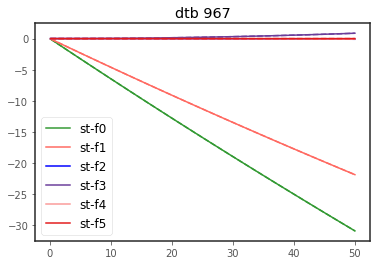

In [338]:
plot_manifold_rates(bright_dark_high_T, title='btd')
plot_manifold_rates(dark_bright_high_T, title='dtb')

[-1.47755742e-03+1.80641990e-13j -1.67914017e-02+7.58147370e-14j
 -3.26077872e-02-2.42183447e-15j -4.89515142e-02-1.72538848e-14j
 -6.58490411e-02-7.18501092e-14j -8.33286256e-02+1.06604651e-13j
 -1.01420480e-01+4.96603062e-15j -1.20156943e-01+1.67042398e-14j
 -1.39572670e-01+3.80161160e-14j -1.59704844e-01+7.81019536e-14j
 -1.80593410e-01+1.44857612e-13j -2.02281339e-01+2.64693629e-13j
 -2.24814913e-01+4.59025630e-13j -2.48244060e-01+7.66648415e-13j
 -2.72622709e-01+5.02234678e-13j -2.98009210e-01+7.86957422e-13j
 -3.24466787e-01+1.20252483e-12j -3.52064063e-01+2.76849301e-14j
 -3.80875649e-01+4.15454074e-14j -4.10982808e-01+6.55776468e-14j
 -4.42474216e-01+9.48431839e-14j -4.75446827e-01+1.38588641e-13j
 -5.10006861e-01+2.00749155e-13j -5.46270938e-01+2.84661350e-13j
 -5.84367382e-01+3.95874596e-13j -6.24437732e-01+5.49908887e-13j
 -6.66638481e-01+7.57139717e-13j -7.11143110e-01+1.03333482e-12j
 -7.58144452e-01+1.39687790e-12j -8.07857477e-01+1.87129771e-12j
 -8.60522551e-01+2.410659

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


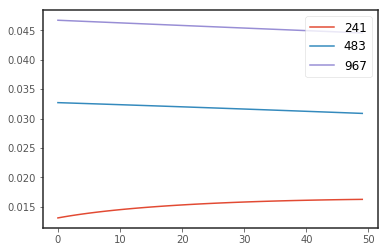

In [296]:
w0_mag = '483'
def fast_bd_population_ratio(gd, gb, dg, db, bg, bd):
    return (gd + gb)/bg

def full_population_ratio(gd, gb, dg, db, bg, bd):
    M = (bd/(bd+bg))
    A = dg + db*(1- M)
    return gd/A + gb*M/A

for w0_mag in ['241', '483', '967']:
    bg_rate = np.array(bright_ground_high_T[w0_mag]['st-f0']['add'])
    gb_rate = np.array(ground_bright_high_T[w0_mag]['st-f0']['add'])
    gd_rate = np.array(ground_dark_high_T[w0_mag]['st-f0']['add'])
    dg_rate = np.array(dark_ground_high_T[w0_mag]['st-f0']['add'])
    db_rate = np.array(dark_bright_high_T[w0_mag]['st-f0']['add'])
    bd_rate = np.array(bright_dark_high_T[w0_mag]['st-f0']['add'])
    #for i in range(5):
    #    db_rate += np.array(dark_bright_high_T[w0_mag]['st-f'+str(i)]['add'])
    #    bd_rate += np.array(bright_dark_high_T[w0_mag]['st-f'+str(i)]['add'])
    #print ((gb_rate+gd_rate)/dg_rate)
    #plt.plot((gb_rate+gd_rate)/dg_rate, label=w0_mag)
    plt.plot(full_population_ratio(gd_rate, gb_rate, dg_rate, db_rate/5, bg_rate, bd_rate/5), label=w0_mag)
    plt.legend()


$|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=0$

$|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=0$

- These rates suggest that the zero phonon transition is the largest between bright and dark.
- The $|\psi_+^{0}\rangle \to |-\rangle$ rate is predicted to be zero, which doesn't make sense. I can't work out why this would be the case, unless it's do with with product state thing again.
- Strangely, increasing $\omega_0$ decreases the bright-to-dark rate. This is exactly the same in both non-additive and additive cases. 

When $\omega_0$ increases, the overlap between ground and exciton states increases due to smaller displacement. This might cause the excitonic coupling to be smaller since these terms gain

$|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=0$ 

# Thermal Occupation of EMF

- $|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=6000$

In [125]:
w_2 = 1.4 * ev_to_inv_cm
bias = 10e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 1e-3 * ev_to_inv_cm
T_EM = 0.
T_ph = 150
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
#w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 80. #2*w0
print (eta, V/eta)

180.35006272524555 0.4472135954999579


In [126]:
dark_ground_ = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='dark', end_manifold='ground')
ground_dark_ = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='ground', end_manifold='dark')

10
20
Error in displacement: 0.55206940%. Predicted -0.5497 , actual -0.5488
Ratio of kBT to Omega: 0.4308
Error in displacement: 0.60811059%. Predicted -0.5633 , actual -0.5623
Ratio of kBT to Omega: 0.4308
Error in displacement: 0.66749169%. Predicted -0.5765 , actual -0.5754
Ratio of kBT to Omega: 0.4308
Error in displacement: 0.73028915%. Predicted -0.5894 , actual -0.5882
Ratio of kBT to Omega: 0.4308
Error in displacement: 0.79657754%. Predicted -0.6020 , actual -0.6007
Ratio of kBT to Omega: 0.4308
Error in displacement: 0.86642953%. Predicted -0.6143 , actual -0.6130
Ratio of kBT to Omega: 0.4308
Error in displacement: 0.93991585%. Predicted -0.6265 , actual -0.6250
Ratio of kBT to Omega: 0.4308
Error in displacement: 1.01710526%. Predicted -0.6383 , actual -0.6368
Ratio of kBT to Omega: 0.4308
Error in displacement: 1.09806452%. Predicted -0.6500 , actual -0.6484
Ratio of kBT to Omega: 0.4308
Error in displacement: 1.18285835%. Predicted -0.6615 , actual -0.6597
Ratio of kBT t

KeyboardInterrupt: 

In [77]:
ground_dark_

{'241': {'st-manifold': {'nonadd': [0.0036370799304901347,
    0.0036361225941570793,
    0.0036351654808529474,
    0.0036342085913821176,
    0.0036332519247738028,
    0.0036322954818549034,
    0.0036313392619572345,
    0.0036303832654682898,
    0.0036294274921595503,
    0.0036284719414502523,
    0.003627516614643467,
    0.003626561510421563,
    0.003625606629621769,
    0.003624651971431415,
    0.003623697537292615,
    0.0036227433253801507,
    0.0036217893358830747,
    0.0036208355693663563,
    0.003619882025790894,
    0.0036189287048214677,
    0.0036179756065891342,
    0.0036170227307864185,
    0.003616070077579817,
    0.003615117647136695,
    0.003614165440034941,
    0.0036132134549289163,
    0.003612261691885424,
    0.0036113101519156497,
    0.0036103588341880647,
    0.0036094077380795938,
    0.0036084568650251955,
    0.003607506213154435,
    0.003606555784341981,
    0.0036056055777374924,
    0.003604655592581076,
    0.003603705830277211,
    0.0036

In [ ]:
plot_manifold_rates(dark_ground_, title='dtg')
plot_manifold_rates(ground_dark_, title='gtd')

In [ ]:
w0_mag = '483'
def full_population_ratio(gd, gb, dg, db, bg, bd):
    A = dg + db*(1- (bd/(bd+bg)))
    return gd/A + (bd*gb)/(A*(bd+bg))

for w0_mag in ['241', '483', '967']:
    bg_rate = np.array(bright_ground[w0_mag]['st-manifold']['nonadd'])
    gb_rate = np.array(ground_bright[w0_mag]['st-manifold']['nonadd'])
    gd_rate = np.array(ground_dark_[w0_mag]['st-manifold']['nonadd'])
    dg_rate = np.array(dark_ground_[w0_mag]['st-manifold']['nonadd'])
    
    db_rate = np.array(dark_bright_high[w0_mag]['st-f0']['nonadd'])
    bd_rate = np.array(bright_dark_high[w0_mag]['st-f0']['nonadd'])
    #print ((gb_rate+gd_rate)/dg_rate)
    #plt.plot((gb_rate+gd_rate)/dg_rate, label=w0_mag)
    plt.plot(full_population_ratio(gd_rate, gb_rate, dg_rate, db_rate, bg_rate, bd_rate), )
    plt.legend()

In [74]:
bright_ground = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='bright', end_manifold='ground')
ground_bright = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='ground', end_manifold='bright')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete


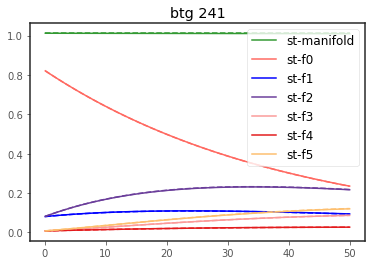

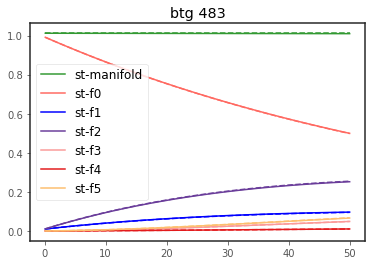

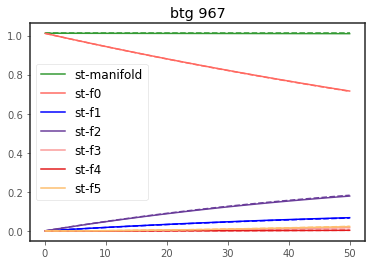

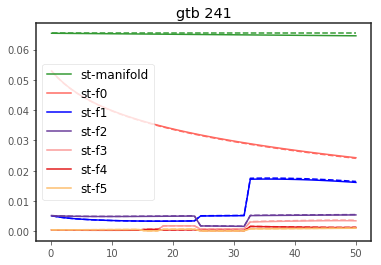

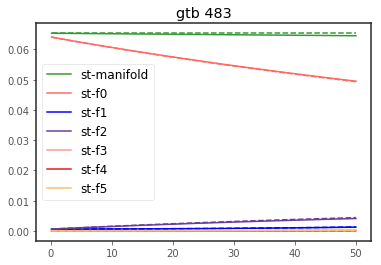

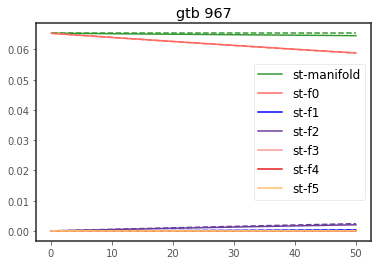

In [75]:
plot_manifold_rates(bright_ground, title='btg')
plot_manifold_rates(ground_bright, title='gtb')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete


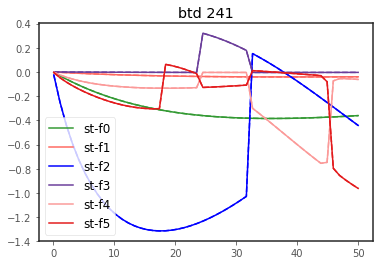

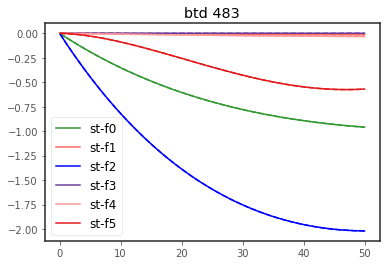

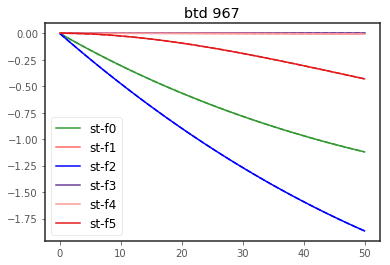

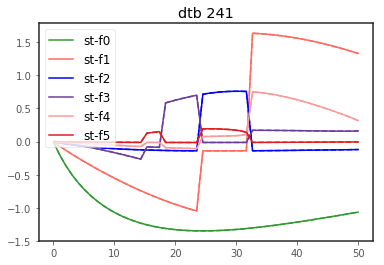

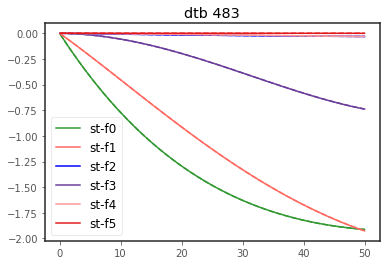

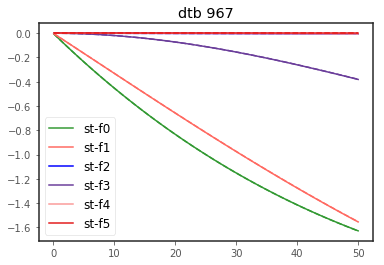

In [76]:
bright_dark_high = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='bright', end_manifold='dark')
dark_bright_high = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='dark', end_manifold='bright')
plot_manifold_rates(bright_dark_high, title='btd')
plot_manifold_rates(dark_bright_high, title='dtb')

$\Gamma_{+,g}$ is not a function of optical field temperature, but $\Gamma_{g,+}$ is.

# $\Gamma_{g,+}/\Gamma_{-,0}$

In [153]:
def pressure_rate(bright_up, bright_down, 
                  dark_up, dark_down, add_type='nonadd'):
    num = np.array(bright_up[add_type])+np.array(dark_up[add_type])
    print (np.array(dark_down[add_type]))
    return num/(np.array(dark_down[add_type]))

def plot_population_pressure(ground_bright, bright_ground, ground_dark, dark_ground):
    # Should be for high EMF temperature
    couplings =ground_bright['couplings']
    plt.figure()
    plt.title(r"$\Gamma_{g,+}/\Gamma_{-,g}$")
    for i, omega_0 in enumerate(ground_bright.keys()):
        if omega_0 == 'couplings':
            pass
        else:
            (bright_up, bright_down, dark_up, dark_down) = (ground_bright[omega_0]['s0-f0'], 
                                                                bright_ground[omega_0]['s0-f0'], 
                                                                ground_dark[omega_0]['s0-f0'], 
                                                                dark_ground[omega_0]['s0-f0'])
            
            #print ((gb_rate+gd_rate)/dg_rate)
            #plt.plot((gb_rate+gd_rate)/dg_rate, label=w0_mag)
            c = colourWheel[i]
            plt.plot(couplings, pressure_rate(bright_up, bright_down, 
                                              dark_up, dark_down, add_type='nonadd'), 
                     linestyle='solid', label=omega_0, c=c)
            plt.plot(couplings, pressure_rate(bright_up, bright_down, 
                                              dark_up, dark_down, add_type='add'), 
                     linestyle='dashed', c=c)
    plt.legend()

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


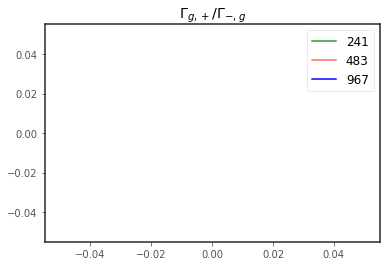

In [45]:
plot_population_pressure(ground_bright_high_T, bright_ground_high_T, ground_dark_high_T, dark_ground_high_T) 

This metric that I have made: the larger it is, the more highly populated the system should be at steadystate

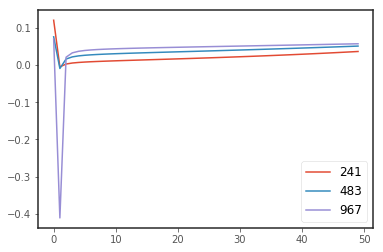

In [155]:
plt.figure()
for w0_mag in ['241', '483', '967']:
    bg_rate = np.array(bright_ground[w0_mag]['st-f0']['add'])
    gb_rate = np.array(ground_bright[w0_mag]['st-f0']['add'])
    gd_rate = np.array(ground_dark_[w0_mag]['st-f0']['add'])
    dg_rate = np.array(dark_ground_[w0_mag]['st-f0']['add'])

    db_rate = np.array(dark_bright_high[w0_mag]['st-f0']['add'])
    bd_rate = np.array(bright_dark_high[w0_mag]['st-f0']['add'])
    plt.plot(full_population_ratio(gd_rate, gb_rate, dg_rate, db_rate, bg_rate, bd_rate), label=w0_mag)
    plt.legend()